<em> Code for Section 4.2, <b>2D Search Space Simulation</b> </em>

In [1]:
# Imports

import torch
import numpy as np
import matplotlib.pyplot as plt
import pyDOE

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.acquisition.analytic import LogConstrainedExpectedImprovement
from botorch.models.model_list_gp_regression import ModelListGP
from gpytorch.mlls import SumMarginalLogLikelihood


In [2]:
# Suppress warnings
import warnings
from botorch.exceptions import InputDataWarning

warnings.filterwarnings("ignore", category=InputDataWarning)

In [3]:
# Latin Hypercube Sampling 

def latin_hypercube_sampling(n_samples, dim, bounds):
    lhs_samples = pyDOE.lhs(dim, samples=n_samples)
    lhs_samples += np.random.uniform(0, 1/n_samples, lhs_samples.shape)
    lhs_samples = np.clip(lhs_samples, 0, 1)
    bounds_np = np.array(bounds)
    scaled_samples = lhs_samples * (bounds_np[1] - bounds_np[0]) + bounds_np[0]
    return torch.tensor(scaled_samples, dtype=torch.float64)

Contour plots of objectives and constraints used in this section

In [4]:
# Define the objective functions
def objective_function1(x, y):
    return np.cos(2 * x) * np.cos(y) + np.sin(x)

def objective_function2(x, y):
    return np.sin(x) + y

# Define the constraint functions
def constraint_function1(x, y):
    return np.cos(x) * np.cos(y) - np.sin(x) * np.sin(y) + 0.5

def constraint_function2(x, y):
    return np.sin(x) * np.sin(y) + 0.95

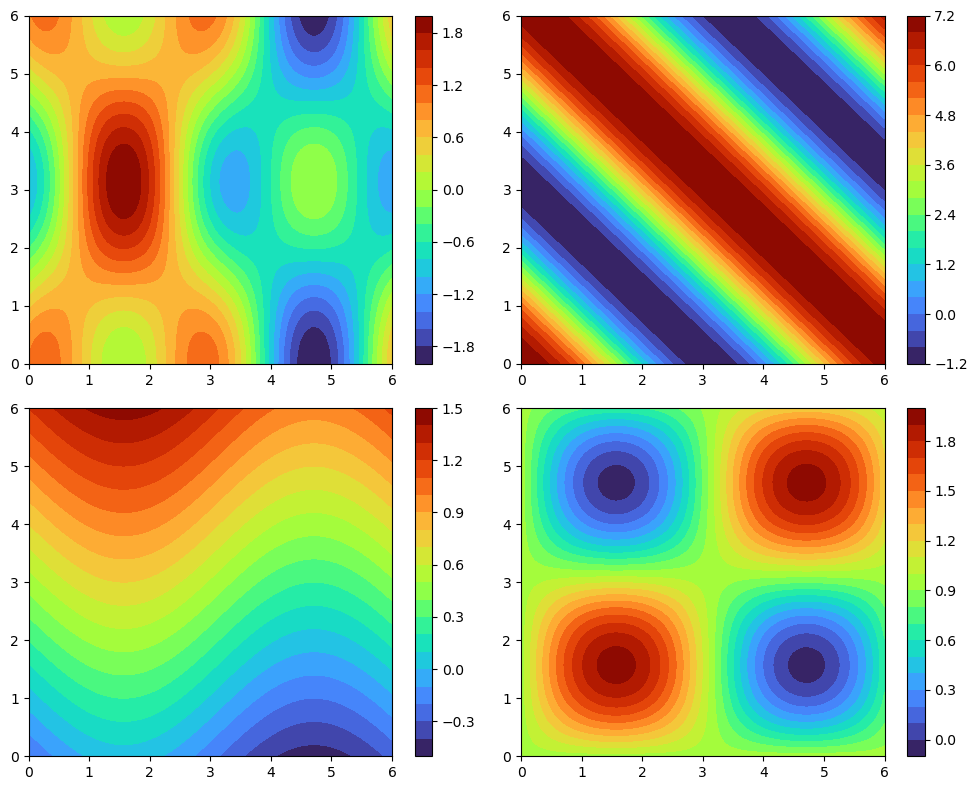

In [5]:
x = np.linspace(0, 6, 100)
y = np.linspace(0, 6, 100)
X, Y = np.meshgrid(x, y)

Z1 = objective_function1(X, Y)
Z2 = objective_function2(X, Y)
Z3 = constraint_function1(X, Y)
Z4 = constraint_function2(X, Y)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the contours
contour1 = axs[0, 0].contourf(X, Y, Z1, levels=20, cmap='turbo')
contour2 = axs[1, 0].contourf(X, Y, Z2, levels=20, cmap='turbo')
contour3 = axs[0, 1].contourf(X, Y, Z3, levels=20, cmap='turbo')
contour4 = axs[1, 1].contourf(X, Y, Z4, levels=20, cmap='turbo')


fig.colorbar(contour1, ax=axs[0, 0])
fig.colorbar(contour2, ax=axs[0, 1])
fig.colorbar(contour3, ax=axs[1, 0])
fig.colorbar(contour4, ax=axs[1, 1])

plt.tight_layout()
plt.show()

In [6]:
dim = 2
bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])
n_samples = 30 

4.2.1 Simulation 1

In [7]:
# Objective function 
def objective_function(x):
    return torch.cos(2 * x[..., 0]) * torch.cos(x[..., 1]) + torch.sin(x[..., 0]) # f(x,y) = cos(2x)cos(y)+sin(x)

# Constraint function
def constraint_function(x):
    return torch.cos(x[..., 0]) * torch.cos(x[..., 1]) - torch.sin(x[..., 0]) * torch.sin(x[..., 1]) + 0.5 # c(x,y) = cos(x)cos(y) - sin(x)sin(y) <= 0.5


Uniform Sampling (Simulation 1)

In [8]:
# Initialise training data

train_X = torch.rand(n_samples, dim) * (bounds[1] - bounds[0]) + bounds[0]
train_Y = objective_function(train_X).unsqueeze(-1)

Total number of points: 30
Number of points inside the feasible region: 9
Best value found: 1.500943899154663
Best parameters: [1.334357500076294, 2.2067489624023438]


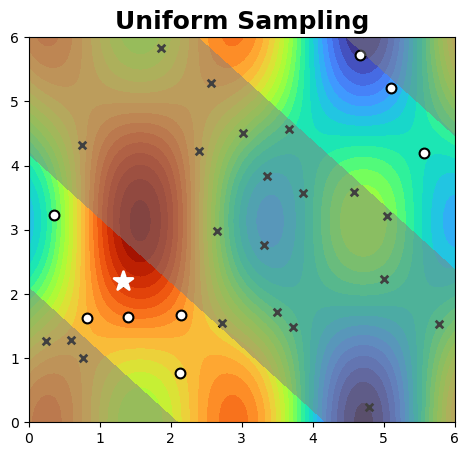

In [9]:
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack(...).T stacks flattened arrays + transposes result for plotting
Y = objective_function(X).numpy().reshape(X1.shape)


plt.figure(figsize=(5.5, 5))

contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')


for i in range(len(train_X)):
    # Check if the point is inside the feasible region
    if constraint_function(train_X[i]).item() < 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)


best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)
total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")
plt.title('Uniform Sampling', fontweight='bold', fontsize=18)
plt.show()

Unconstrained BO (Simulation 1)

In [10]:
dim = 2
bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])
n_initial = 5
n_iterations = 25
batch_size = 1 # one point per iteration

In [11]:
# initialise training data
train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_Y = objective_function(train_X).unsqueeze(-1)

In [12]:
# Create a grid for plotting
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack..T stacks flattened arrays + transposes result
Y = objective_function(X).numpy().reshape(X1.shape)

# optimisation loop

for i in range(n_iterations):
    
    # Fitting the model
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    EI = LogExpectedImprovement(model=model, best_f=train_Y.max())

    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=batch_size,
        num_restarts=40,
        raw_samples=1024,
    )

    # evaluate obkective at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)

    # append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

Iteration 1: Best value so far: 0.7528073479481334
Iteration 2: Best value so far: 0.7528073479481334
Iteration 3: Best value so far: 1.7462513446807861
Iteration 4: Best value so far: 1.7462513446807861
Iteration 5: Best value so far: 1.9878615140914917
Iteration 6: Best value so far: 1.9878615140914917
Iteration 7: Best value so far: 1.9940491914749146
Iteration 8: Best value so far: 1.9940491914749146
Iteration 9: Best value so far: 1.9940491914749146
Iteration 10: Best value so far: 1.9940491914749146
Iteration 11: Best value so far: 1.9940491914749146
Iteration 12: Best value so far: 1.9940491914749146
Iteration 13: Best value so far: 1.9940491914749146
Iteration 14: Best value so far: 1.9940491914749146
Iteration 15: Best value so far: 1.9944517612457275
Iteration 16: Best value so far: 1.9944517612457275
Iteration 17: Best value so far: 1.9963606595993042
Iteration 18: Best value so far: 1.9963606595993042
Iteration 19: Best value so far: 1.9963606595993042
Iteration 20: Best va

Total number of points: 30
Number of points inside the feasible region: 6
Best value found: 1.999899983406067
Best parameters: [1.5722726583480835, 3.1278393268585205]


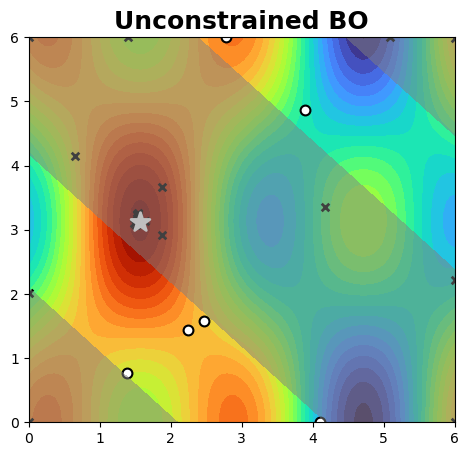

In [13]:
plt.figure(figsize=(5.5, 5))


contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')

for i in range(len(train_X)):
    if constraint_function(train_X[i]).item() < 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)


best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)


total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")

plt.title('Unconstrained BO', fontweight='bold', fontsize=18)
plt.show()


Constrained BO (Simulation 1)

In [14]:
# initialise training data
train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_Y = objective_function(train_X).unsqueeze(-1)
train_C = constraint_function(train_X).unsqueeze(-1)

In [15]:
# Create a grid for plotting
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack..T stacks flattened arrays + transposes result
Y = objective_function(X).numpy().reshape(X1.shape)

# Optimisation loop
for i in range(n_iterations):
    
    # Fit the models
    model_obj = SingleTaskGP(train_X, train_Y)
    model_con = SingleTaskGP(train_X, train_C)
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    # Constrained Expected Improvement
    CEI = LogConstrainedExpectedImprovement(
        model=model,
        best_f=train_Y[train_C.squeeze() <= 0].max(),
        objective_index=0,
        constraints={1: (None, 0)},
    )


    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=CEI,
        bounds=bounds,
        q=batch_size,
        num_restarts=40,
        raw_samples=1024,
    )

    # Evaluate objective and constraint at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)
    new_C = constraint_function(candidates).unsqueeze(-1)
    # Append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])
    train_C = torch.cat([train_C, new_C])
    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

Iteration 1: Best value so far: 1.7718415260314941
Iteration 2: Best value so far: 1.7718415260314941
Iteration 3: Best value so far: 1.7718415260314941
Iteration 4: Best value so far: 1.7718415260314941
Iteration 5: Best value so far: 1.8716992139816284


/Users/juliamanger/anaconda3/lib/python3.11/site-packages/botorch/optim/optimize.py:568: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iteration 6: Best value so far: 1.8716992139816284
Iteration 7: Best value so far: 1.8716992139816284
Iteration 8: Best value so far: 1.878395915031433
Iteration 9: Best value so far: 1.8819828033447266
Iteration 10: Best value so far: 1.8839874267578125
Iteration 11: Best value so far: 1.8851852416992188
Iteration 12: Best value so far: 1.8861658573150635
Iteration 13: Best value so far: 1.8861658573150635
Iteration 14: Best value so far: 1.8861658573150635
Iteration 15: Best value so far: 1.8861658573150635
Iteration 16: Best value so far: 1.8861658573150635
Iteration 17: Best value so far: 1.8867735862731934
Iteration 18: Best value so far: 1.8870570659637451
Iteration 19: Best value so far: 1.8876233100891113
Iteration 20: Best value so far: 1.8876233100891113
Iteration 21: Best value so far: 1.8876233100891113
Iteration 22: Best value so far: 1.8876233100891113


/Users/juliamanger/anaconda3/lib/python3.11/site-packages/botorch/optim/optimize.py:568: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)


Iteration 23: Best value so far: 1.8876233100891113
Iteration 24: Best value so far: 1.8876233100891113
Iteration 25: Best value so far: 1.8876233100891113


Total number of points: 30
Number of points inside the feasible region: 20
Best value found: 1.8876233100891113
Best parameters: [1.482474446296692, 2.703620195388794]


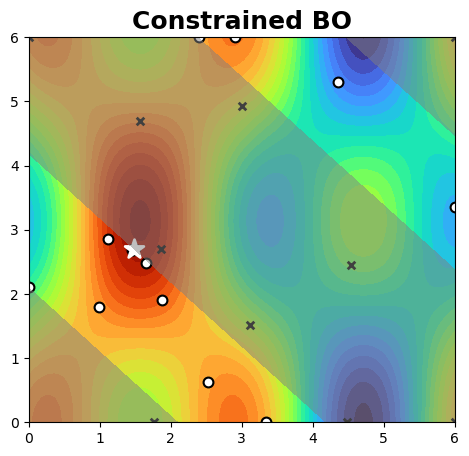

In [16]:
plt.figure(figsize=(5.5, 5))

contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')

for i in range(len(train_X)):
    # Check if the point is inside the feasible region
    if constraint_function(train_X[i]).item() < 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)

best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)

Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)

total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")


plt.title('Constrained BO', fontweight='bold', fontsize=18)
plt.show()

4.2.2 Simulation 2

In [17]:
# Objective function 
def objective_function(x):
    return torch.sin(x[..., 0]) + x[..., 1] #sin(x) + y

# Constraint function
def constraint_function(x):
    return torch.sin(x[..., 0]) * torch.sin(x[..., 1]) + 0.95 # c(x,y) = sin(x) * sin(y) <= -0.95

Uniform Sampling (Simulation 2)

In [18]:
# Initialise training data

train_X = torch.rand(n_samples, dim) * (bounds[1] - bounds[0]) + bounds[0]
train_Y = objective_function(train_X).unsqueeze(-1)

Total number of points: 30
Number of points inside the feasible region: 0
Best value found: 6.393186569213867
Best parameters: [2.440875291824341, 5.748420238494873]


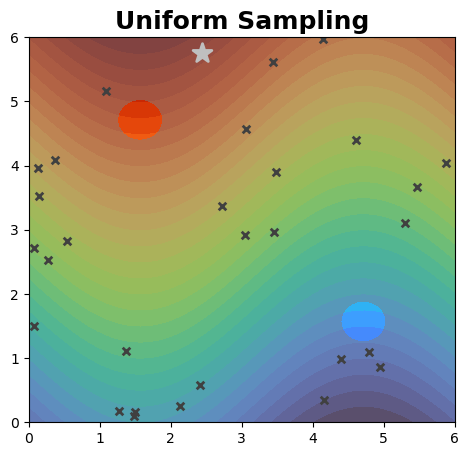

In [19]:
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack(...).T stacks flattened arrays + transposes result for plotting
Y = objective_function(X).numpy().reshape(X1.shape)


plt.figure(figsize=(5.5, 5))

contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')


for i in range(len(train_X)):
    if constraint_function(train_X[i]).item() < 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)


best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)
total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")
plt.title('Uniform Sampling', fontweight='bold', fontsize=18)
plt.show()

Unconstrained BO (Simulation 2)

In [20]:
dim = 2
bounds = torch.tensor([[0.0, 0.0], [6.0, 6.0]])
n_initial = 5
n_iterations = 25
batch_size = 1 # one point per iteration

In [21]:
# initialise training data
train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_Y = objective_function(train_X).unsqueeze(-1)

In [22]:
# Create a grid for plotting
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack..T stacks flattened arrays + transposes result
Y = objective_function(X).numpy().reshape(X1.shape)

# optimisation loop

for i in range(n_iterations):
    
    # Fitting the model
    model = SingleTaskGP(train_X, train_Y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
    EI = LogExpectedImprovement(model=model, best_f=train_Y.max())

    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=EI,
        bounds=bounds,
        q=batch_size,
        num_restarts=40,
        raw_samples=1024,
    )

    # evaluate obkective at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)

    # append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

Iteration 1: Best value so far: 5.674647936257194
Iteration 2: Best value so far: 5.674647936257194
Iteration 3: Best value so far: 6.525508880615234
Iteration 4: Best value so far: 6.868496417999268
Iteration 5: Best value so far: 6.987082481384277
Iteration 6: Best value so far: 6.9913010597229
Iteration 7: Best value so far: 6.9913010597229
Iteration 8: Best value so far: 6.9913010597229
Iteration 9: Best value so far: 6.9913010597229
Iteration 10: Best value so far: 6.9913010597229
Iteration 11: Best value so far: 6.9913010597229
Iteration 12: Best value so far: 6.9913010597229
Iteration 13: Best value so far: 6.9913010597229
Iteration 14: Best value so far: 6.999972343444824
Iteration 15: Best value so far: 6.999972343444824
Iteration 16: Best value so far: 6.999972343444824
Iteration 17: Best value so far: 6.999972343444824
Iteration 18: Best value so far: 6.999972343444824
Iteration 19: Best value so far: 6.999972343444824
Iteration 20: Best value so far: 6.999972343444824
Itera

Total number of points: 30
Number of points inside the feasible region: 1
Best value found: 6.999996662139893
Best parameters: [1.5681523084640503, 6.0]


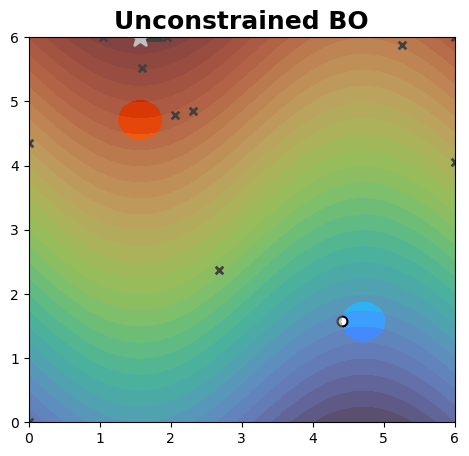

In [23]:
plt.figure(figsize=(5.5, 5))


contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')

for i in range(len(train_X)):
    if constraint_function(train_X[i]).item() < 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)


best_idx = train_Y.argmax()
plt.scatter(train_X[best_idx, 0], train_X[best_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)
Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)


total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(constraint_function(train_X).squeeze() <= 0).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")

plt.title('Unconstrained BO', fontweight='bold', fontsize=18)
plt.show()


Constrained BO (Simulation 2)

In [24]:
# Initialise training data
train_X = latin_hypercube_sampling(n_initial, dim, bounds)
train_Y = objective_function(train_X).unsqueeze(-1)
train_C = constraint_function(train_X).unsqueeze(-1)

In [25]:
# optimisation loop

for i in range(n_iterations):
    
    # Fit the models
    model_obj = SingleTaskGP(train_X, train_Y)
    model_con = SingleTaskGP(train_X, train_C)
    model = ModelListGP(model_obj, model_con)
    mll = SumMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    
   # Handle case when no feasible points exist
    if train_Y[train_C.squeeze() <= 0].numel() == 0:
        best_f = train_Y.min()  # or another appropriate default value
    else:
        best_f = train_Y[train_C.squeeze() <= 0].max()

    EIC = LogConstrainedExpectedImprovement(
        model=model,
        best_f=best_f,
        objective_index=0,
        constraints={1: (None, 0)},
    )


    # Optimise the acquisition function
    candidates, _ = optimize_acqf(
        acq_function=EIC,
        bounds=bounds,
        q=batch_size,
        num_restarts=40,
        raw_samples=1024,
    )

    # Evaluate objective and constraint at new candidate point
    new_Y = objective_function(candidates).unsqueeze(-1)
    new_C = constraint_function(candidates).unsqueeze(-1)

    # Append new data to the training data
    train_X = torch.cat([train_X, candidates])
    train_Y = torch.cat([train_Y, new_Y])
    train_C = torch.cat([train_C, new_C])

    # Print progress
    print(f"Iteration {i+1}: Best value so far: {train_Y.max().item()}")

Iteration 1: Best value so far: 5.37038645097381
Iteration 2: Best value so far: 5.654669284820557
Iteration 3: Best value so far: 6.7557268142700195
Iteration 4: Best value so far: 6.7557268142700195
Iteration 5: Best value so far: 6.7557268142700195
Iteration 6: Best value so far: 6.7557268142700195
Iteration 7: Best value so far: 6.7557268142700195
Iteration 8: Best value so far: 6.7557268142700195
Iteration 9: Best value so far: 6.7557268142700195
Iteration 10: Best value so far: 6.7557268142700195
Iteration 11: Best value so far: 6.7557268142700195
Iteration 12: Best value so far: 6.7557268142700195
Iteration 13: Best value so far: 6.7557268142700195
Iteration 14: Best value so far: 6.7557268142700195
Iteration 15: Best value so far: 6.7557268142700195
Iteration 16: Best value so far: 6.7557268142700195
Iteration 17: Best value so far: 6.7557268142700195
Iteration 18: Best value so far: 6.7557268142700195
Iteration 19: Best value so far: 6.7557268142700195
Iteration 20: Best value

Total number of points: 30
Number of points inside the feasible region: 5
Best value found: 6.7557268142700195
Best parameters: [1.8851279020309448, 5.804723739624023]


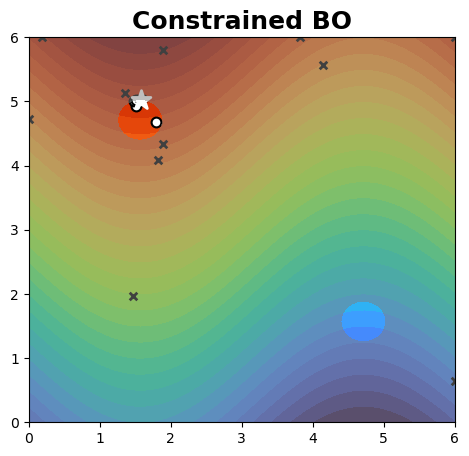

In [26]:
x1 = np.linspace(0, 6, 100)
x2 = np.linspace(0, 6, 100)
X1, X2 = np.meshgrid(x1, x2)
X = torch.from_numpy(np.vstack((X1.ravel(), X2.ravel())).T).float() # np.ravel flattens arrays, np.vstack..T stacks flattened arrays + transposes result
Y = objective_function(X).numpy().reshape(X1.shape)

plt.figure(figsize=(5.5, 5))

contour = plt.contourf(X1, X2, Y, levels=35, cmap='turbo')

for i in range(len(train_X)):
    # Check if the point is inside the feasible region
    if constraint_function(train_X[i]).item() <= 0:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='white', edgecolor='black', s=50, label='Evaluated Points' if i == 0 else "", linewidth=1.5)
    else:
        plt.scatter(train_X[i, 0], train_X[i, 1], c='black', s=30, marker='x', label='Infeasible Points' if i == 0 else "", linewidth=2)

feasible_mask = constraint_function(train_X).squeeze() <= 0
feasible_X = train_X[feasible_mask]
feasible_Y = train_Y[feasible_mask]

best_feasible_idx = torch.argmax(feasible_Y)
plt.scatter(feasible_X[best_feasible_idx, 0], feasible_X[best_feasible_idx, 1], c='white', s=200, marker='*', label='Best Point', linewidth=2)

Z = constraint_function(X).numpy().reshape(X1.shape)
plt.contourf(X1, X2, Z, levels=[0, Z.max()], colors='gray', alpha=0.5)


total_points = train_X.size(0)
print(f"Total number of points: {total_points}")
feasible_count = torch.sum(feasible_mask).item()
print(f"Number of points inside the feasible region: {feasible_count}")
print(f"Best value found: {train_Y.max().item()}")
print(f"Best parameters: {train_X[torch.argmax(train_Y)].tolist()}")

plt.title('Constrained BO', fontweight='bold', fontsize=18)
plt.show()
